In [36]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import pinyin

In [2]:
files = [file for file in os.listdir("Station_data")]

In [3]:
rows = []
for file in files:
    with open("./Station_Data/" + file) as f:
        lines = f.readlines()[1:]
        lines = [line.split(",") for line in lines]
        for line in lines:
            rows.append((file, line[0], line[1].strip("\n")))

In [4]:
ridership = pd.DataFrame(rows, columns=["station_1", "station_2", "trains"])
ridership.head(3)

,station_1,station_2,trains
0,Achengbei Railway Station,Haerbinxi Railway Station,97
1,Achengbei Railway Station,Haerbin Railway Station,112
2,Achengbei Railway Station,Shangzhinan Railway Station,252


In [95]:
strip_list = [" Railway Station"]
end_strip_list = ["bei", "xi", "nan", "dong"]

def strip_from_list(s: str):
    for item in strip_list:
        s = s.replace(item, "")

    for item in end_strip_list:
        if s[len(s) - len(item):] == item:
            s = s[: len(s) - len(item)]
    
    return s.lower()

ridership["s1_strip"] = ridership["station_1"].apply(lambda x: strip_from_list(x))
ridership["s2_strip"] = ridership["station_2"].apply(lambda x: strip_from_list(x))
ridership.head(2)

,station_1,station_2,trains,s1_strip,s2_strip
0,Achengbei Railway Station,Haerbinxi Railway Station,97,acheng,haerbin
1,Achengbei Railway Station,Haerbin Railway Station,112,acheng,haerbin


In [8]:
lines = gpd.read_file("./stations_geo/China_HSR_2016_lines.shp")
stations = gpd.read_file("./stations_geo/China_HSR_2016_stations.shp")

In [34]:
stations["name"] = stations["NAME_ZH"].apply(
    lambda x: GoogleTranslator(source="zh-CN", target="en").translate(x)
)
stations.head(3)

,OBJECTID,NAME_ZH,speed_kph,line_name,KML_FOLDER,geometry,name
0,1,华容,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (114.73729 30.52040 0.00000),Huarong
1,2,黄石,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (114.93489 30.15640 0.00000),yellowstone
2,3,阳新,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (115.17481 29.86132 0.00000),Yangxin


In [37]:
stations["romanized"] = stations["NAME_ZH"].apply(
    lambda x: pinyin.get(x, format="strip")
)
stations.head(3)

,OBJECTID,NAME_ZH,speed_kph,line_name,KML_FOLDER,geometry,name,romanized
0,1,华容,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (114.73729 30.52040 0.00000),Huarong,huarong
1,2,黄石,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (114.93489 30.15640 0.00000),yellowstone,huangshi
2,3,阳新,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (115.17481 29.86132 0.00000),Yangxin,yangxin


In [69]:
rider = set(ridership["s1_strip"]).difference(set(stations["romanized"]))
print(len(rider))

278


In [70]:
in_harvard = set(stations["romanized"]).difference(set(ridership["s1_strip"]))
print(len(in_harvard))

301


In [47]:
stations_w_riders = ridership.merge(
    stations,
    how="left",
    left_on="s1_strip",
    right_on="romanized"
)
print(len(stations_w_riders[stations_w_riders["romanized"].notna()]))
len(stations_w_riders)

4346


5704

In [96]:
metros = pd.read_parquet("./data/metro_regions.parquet")
metros["metro"] = metros["metro"].str.lower()

In [104]:
metros.sort_values(by="population", ascending=False).head(20)

,metro,country_code,geometry,population,cities
0,shenzhen,CN,POINT (12698025.071654 2577151.127226),36825407,"[Nam Cheong, Wan Chai, Tseung Kwan O, Tai Koo,..."
2,langfang,CN,POINT (12992622.085285 4796547.206012),30051058,"[Tianjin, Beijing]"
1,tokyo,JP,POINT (15550410.025242 4257980.732184),23736774,"[Oami, Higashikurume, Wako, Ushiku, Togane, Zu..."
4,new york city,US,POINT (-8238306.896062 4970287.468207),16427587,"[The Bronx, Woodhaven, Hoboken, Wakefield, Pis..."
10,osaka,JP,POINT (15084033.678978 4122339.128685),14313749,"[Muko, Moriguchi, Tenri, Kainan, Habikino, Kaw..."
5,jakarta,ID,POINT (11893945.465341 -693168.833008),13913082,"[Depok, Cikupa, Caringin, Tangerang, Sukabumi,..."
8,wuxi,CN,POINT (13390462.360651 3706850.21523),13071777,"[Jiangyin, Yixing, Changzhou, Suzhou]"
6,seoul,KR,POINT (14135170.829745 4518296.290059),11834000,"[Icheon-si, Seongnam-si, Guri-si, Pubal, Uijeo..."
19,jiaozhou,CN,POINT (13358709.589097 4339754.838816),9207230,"[Yunshan, Qingdao, Zhu Cheng City, Jiangzhuang..."
13,los angeles,US,POINT (-13162826.247123 4035817.397012),9101529,"[North Hills, Santa Ana, Diamond Bar, Alhambra..."


In [103]:
metros[metros["country_code"] == "CN"]

,metro,country_code,geometry,population,cities
0,shenzhen,CN,POINT (12698025.071654 2577151.127226),36825407,"[Nam Cheong, Wan Chai, Tseung Kwan O, Tai Koo,..."
2,langfang,CN,POINT (12992622.085285 4796547.206012),30051058,"[Tianjin, Beijing]"
3,shanghai,CN,POINT (13520649.391939 3661642.392781),4165757,"[Songjiang, Huilong, Taicang, Zhabei, Jiashan,..."
8,wuxi,CN,POINT (13390462.360651 3706850.21523),13071777,"[Jiangyin, Yixing, Changzhou, Suzhou]"
11,chengdu,CN,POINT (11584648.712952 3589535.140316),851454,"[Deyang, Tianpeng, Linqiong]"
...,...,...,...,...,...
583,jalai nur,CN,POINT (13102304.066368 6351564.799962),54808,[Manzhouli]
586,yebaishou,CN,POINT (13318356.273685 5071150.808536),91418,[Lingyuan]
595,chengxian chengguanzhen,CN,POINT (11770137.040876 3994981.097246),78604,"[Huixian Chengguanzhen, Shili]"
599,dushanzi,CN,POINT (9445458.793809 5517171.507251),72587,[Wusu]


In [99]:
stations_w_pop = ridership.merge(
    metros, how="left", left_on="s1_strip", right_on="metro"
)
stations_w_pop[
    stations_w_pop["metro"].notna()
]

,station_1,station_2,trains,s1_strip,s2_strip,metro,country_code,geometry,population,cities
115,Baodingdong Railway Station,Tianjinxi Railway Station,111,baoding,tianjin,baoding,CN,POINT (12853222.252939 4703479.046194),295615.0,"[Renqiu, Dingzhou, Beiwangli]"
116,Baodingdong Railway Station,Shijiazhuang Railway Station,5424,baoding,shijiazhuang,baoding,CN,POINT (12853222.252939 4703479.046194),295615.0,"[Renqiu, Dingzhou, Beiwangli]"
117,Baodingdong Railway Station,Dingzhoudong Railway Station,998,baoding,dingzhou,baoding,CN,POINT (12853222.252939 4703479.046194),295615.0,"[Renqiu, Dingzhou, Beiwangli]"
118,Baodingdong Railway Station,Baiyangdian Railway Station,1387,baoding,baiyangdian,baoding,CN,POINT (12853222.252939 4703479.046194),295615.0,"[Renqiu, Dingzhou, Beiwangli]"
119,Baodingdong Railway Station,Baigou Railway Station,443,baoding,baigou,baoding,CN,POINT (12853222.252939 4703479.046194),295615.0,"[Renqiu, Dingzhou, Beiwangli]"
...,...,...,...,...,...,...,...,...,...,...
5555,Zibobei Railway Station,Weifangbei Railway Station,589,zibo,weifang,zibo,CN,POINT (13142749.776958 4409953.620924),2659273.0,"[Taitou, Sitou, Dongxia, Qingzhou, Miaozi, Jit..."
5556,Zibobei Railway Station,Linzibei Railway Station,1336,zibo,linzi,zibo,CN,POINT (13142749.776958 4409953.620924),2659273.0,"[Taitou, Sitou, Dongxia, Qingzhou, Miaozi, Jit..."
5557,Zibobei Railway Station,Zhangqiubei Railway Station,1452,zibo,zhangqiu,zibo,CN,POINT (13142749.776958 4409953.620924),2659273.0,"[Taitou, Sitou, Dongxia, Qingzhou, Miaozi, Jit..."
5558,Zibobei Railway Station,Zouping Railway Station,1215,zibo,zouping,zibo,CN,POINT (13142749.776958 4409953.620924),2659273.0,"[Taitou, Sitou, Dongxia, Qingzhou, Miaozi, Jit..."


In [100]:
stations_w_pop[stations_w_pop["metro"].isna()]["s1_strip"].unique()

array(['acheng', 'afanggong', 'anda', 'anjiang', 'anlu', 'anqing',
       'anshan', 'anshun', 'anting', 'antu', 'anyang',
       'badalingchangcheng', 'ba', 'baigou', 'baishapu', 'baiyangdian',
       'bangbu', 'baohuashan', 'baoji', 'bazhou', 'beidaihe', 'beihai',
       'beijing', 'beipiao', 'ben', 'benxixincheng', 'bijie', 'binhai',
       'binhaigang', 'binyang', 'bishan', 'boyuquan', 'cang', 'changge',
       'changle', 'changlinhe', 'changning', 'changping', 'changshou',
       'changshouhu', 'changting', 'changtu', 'changxing', 'changzhou',
       'chaohu', 'chaoshan', 'chaoyang', 'chasuqi', 'chengde',
       'chengdexian', 'chenggu', 'chenzhou', 'chibi', 'chuzhou',
       'congjiang', 'dafang', 'dagushan', 'dalian', 'daminghu', 'dan',
       'dangshan', 'dangtu', 'danyang', 'daye', 'dazu', 'dean', 'dehui',
       'dengzhou', 'deqing', 'dexing', 'deyang', 'dezhou', 'dianjiang',
       'ding', 'dingyuan', 'dingzhou', 'dongan', 'dongdaihe', 'donggang',
       'donghuayuan', 'dongj

In [76]:
ridership["s1_strip"].apply(
    lambda x: any(x in s for s in stations["romanized"].unique())
).count()

5600

In [48]:
stations_w_riders[stations_w_riders["romanized"].isna()]

,station_1,station_2,trains,s1_strip,s2_strip,OBJECTID,NAME_ZH,speed_kph,line_name,KML_FOLDER,geometry,name,romanized
0,Achengbei Railway Station,Haerbinxi Railway Station,97,achengbei,haerbinxi,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
1,Achengbei Railway Station,Haerbin Railway Station,112,achengbei,haerbin,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2,Achengbei Railway Station,Shangzhinan Railway Station,252,achengbei,shangzhinan,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
3,Achengbei Railway Station,Maoershanxi Railway Station,14,achengbei,maoershanxi,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
4,Afanggong Railway Station,Hanzhong Railway Station,112,afanggong,hanzhong,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699,Zunyinan Railway Station,Guiyangbei Railway Station,112,zunyinan,guiyangbei,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
5700,Zunyinan Railway Station,Guiyangdong Railway Station,112,zunyinan,guiyangdong,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
5701,Zunyinan Railway Station,Qijiangdong Railway Station,29,zunyinan,qijiangdong,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
5702,Zunyinan Railway Station,Xiuwenxian Railway Station,3,zunyinan,xiuwenxian,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


<Axes: >

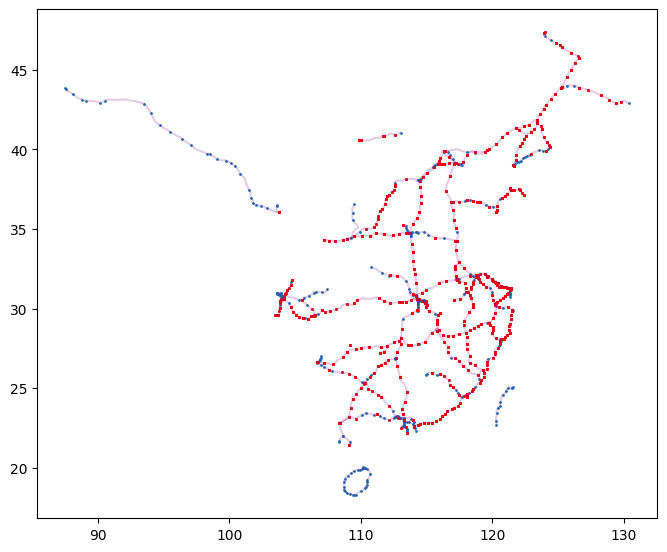

In [68]:
fig, ax = plt.subplots(figsize=(8,8))
lines.plot(ax=ax, color="purple", markersize=0.01, alpha=0.2)
stations.plot(ax=ax, markersize=1)
gpd.GeoDataFrame(stations_w_riders[
    stations_w_riders["geometry"].notna()
]).plot(ax=ax, color="red", markersize=1)